In [1]:
# IMPORTS
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import random
import os

from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
tqdm.pandas()

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
BATCH_SIZE = 64
EMBEDDING_DIM = 50
UNITS = 50
NUM_EPOCHS = 20
max_lines = 180000

In [3]:
def preprocess(sent, exclude, sp_tokens=False):
    sent = sent.lower()
    sent = re.sub("'", '', sent)
    sent = ''.join(ch for ch in sent if ch not in exclude)
    sent = sent.strip()
    sent = re.sub(" +", " ", sent)
    if sp_tokens:
        sent = '<start> ' + sent + ' <end>'
    
    return sent


In [4]:
from keras.preprocessing.text import Tokenizer

def Tokenize(text):
    tokenizer = Tokenizer(oov_token="<unk>",filters='!"#$%&()*+,-/:;=@[\\]^_`{|}~\t\n')
    tokenizer.fit_on_texts(text)
    return tokenizer

In [5]:
# padding
def pad_sequences(x, max_len):
    padded = tf.keras.preprocessing.sequence.pad_sequences(x, maxlen=max_len, padding='post', truncating='post')
    return padded

In [6]:
def load_data(path):
    with open(path, "r", encoding="utf-8") as f:
        lines = f.read().split("\n")
    return lines

In [7]:
lines = load_data("eng_ger.txt")
lines = lines[:max_lines]

print(lines[:5])

['Hi.\tHallo!', 'Hi.\tGrüß Gott!', 'Run!\tLauf!', 'Wow!\tPotzdonner!', 'Wow!\tDonnerwetter!']


In [8]:
def swap_lines(lines):
    print(lines[:5])
    data = []
    for line in lines:
        text = line.split("\t")
        str = text[1] + "\t" + text[0]
        data.append(str)
    return data

lines = swap_lines(lines)
print(lines[:5])

['Hi.\tHallo!', 'Hi.\tGrüß Gott!', 'Run!\tLauf!', 'Wow!\tPotzdonner!', 'Wow!\tDonnerwetter!']
['Hallo!\tHi.', 'Grüß Gott!\tHi.', 'Lauf!\tRun!', 'Potzdonner!\tWow!', 'Donnerwetter!\tWow!']


In [9]:
def combine(lines):
    data = []
    exclude = string.punctuation
    for line in lines:
        text = line.split("\t")
        prep_inp = preprocess(text[0], exclude=exclude, sp_tokens=False)
        prep_tar = preprocess(text[1], exclude=exclude, sp_tokens=True)
        data.append([prep_inp, prep_tar])
    
    print(data[:5])
    
    # tokenize
    inp_tokenizer = Tokenize([i[0] for i in data])
    tar_tokenizer = Tokenize([i[1] for i in data])

    # convert text to sequences
    inp_seq = inp_tokenizer.texts_to_sequences([i[0] for i in data])
    tar_seq = tar_tokenizer.texts_to_sequences([i[1] for i in data])

    print(inp_seq[:5])
    print(tar_seq[:5])

    # padding
    inp_seq = pad_sequences(inp_seq, max_len=10)
    tar_seq = pad_sequences(tar_seq, max_len=10)

    print(inp_seq[:5])
    print(tar_seq[:5])

    input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(inp_seq, tar_seq, test_size=0.2)

    train_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(len(input_tensor_train))
    train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

    test_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val)).shuffle(len(input_tensor_val))
    test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

    return train_dataset, test_dataset, inp_tokenizer, tar_tokenizer
    
    


In [10]:
train_dataset, test_dataset, inp_tokenizer, tar_tokenizer = combine(lines)
input_vocab_size = len(inp_tokenizer.word_index) + 1
target_vocab_size = len(tar_tokenizer.word_index) + 1

[['hallo', '<start> hi <end>'], ['grüß gott', '<start> hi <end>'], ['lauf', '<start> run <end>'], ['potzdonner', '<start> wow <end>'], ['donnerwetter', '<start> wow <end>']]
[[1596], [4077, 1513], [4508], [10094], [12452]]
[[2, 2059, 3], [2, 2059, 3], [2, 461, 3], [2, 3726, 3], [2, 3726, 3]]
[[ 1596     0     0     0     0     0     0     0     0     0]
 [ 4077  1513     0     0     0     0     0     0     0     0]
 [ 4508     0     0     0     0     0     0     0     0     0]
 [10094     0     0     0     0     0     0     0     0     0]
 [12452     0     0     0     0     0     0     0     0     0]]
[[   2 2059    3    0    0    0    0    0    0    0]
 [   2 2059    3    0    0    0    0    0    0    0]
 [   2  461    3    0    0    0    0    0    0    0]
 [   2 3726    3    0    0    0    0    0    0    0]
 [   2 3726    3    0    0    0    0    0    0    0]]


In [11]:
print(train_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(64, 10), dtype=tf.int32, name=None), TensorSpec(shape=(64, 10), dtype=tf.int32, name=None))>


In [12]:
def detokenize(token,tokenizer):
    # token = token.numpy()
    res = ""
    for i in token:
        if i!=0:
            if(tokenizer.index_word[i]=="<end>"):
                break
            if(tokenizer.index_word[i]=="<start>"):
                continue
            res += tokenizer.index_word[i] + " "
    return res



In [13]:
# 2 layers => 1 embedding layer and 1 LSTM layer

class Encoder(tf.keras.layers.Layer):
    
    def __init__(self, embed_dim, units, vocab_size):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(
            vocab_size, embed_dim, mask_zero=True)
        self.rnn = tf.keras.layers.LSTM(
            units, return_sequences=True, return_state=True)
    
    def call(self, x):
        # x => (batch_size, max_len)
        x = self.embedding(x) # => (batch_size, s, embed_dim)
        enc_outputs = self.rnn(x)
        return enc_outputs[0], enc_outputs[1:]


In [14]:
class AdditiveAttention(tf.keras.layers.Layer):

    def __init__(self, units):
        super().__init__()
        self.W_q = tf.keras.layers.Dense(units, use_bias=False)
        self.W_k = tf.keras.layers.Dense(units, use_bias=False)
        self.W_v = tf.keras.layers.Dense(1, use_bias=False)
    

    def call(self, query, key, value, mask=None):
        query, key = self.W_q(query), self.W_k(key)
        # query => (batch_size, t, units)
        # key => (batch_size, s, units)

        score = self.W_v(
            tf.math.tanh(
                tf.expand_dims(query, 2) + tf.expand_dims(key, 1)
            )
        )
        score = tf.squeeze(score, -1)
        # score => (batch_size, t, s)
        
        if mask is not None:
            score = tf.where(mask, score, -1e6)
        
        attention_weights = tf.nn.softmax(score, axis=-1)
        # attention_weights => (batch_size, t, s)

        context = tf.matmul(attention_weights, value)
        # context => (batch_size, t, units)

        return context, attention_weights


In [15]:
class Decoder(tf.keras.layers.Layer):

    def __init__(self, embed_dim, units, vocab_size):
        super().__init__()

        # Embedding layer to convert tokens to vectors
        self.embedding = tf.keras.layers.Embedding(
            vocab_size, embed_dim, mask_zero=True)
        
        # RNN layer
        self.rnn = tf.keras.layers.LSTM(
            units, return_sequences=True, return_state=True)
        
        # Attention layer
        self.attention = AdditiveAttention(units)

        # Final layer to output logits, we can use 
        # argmax to know which output token is predicted.
        self.fc = tf.keras.layers.Dense(vocab_size)
    

    def call(self, x, enc_outputs, state, mask=None):
        x = self.embedding(x)
        # x => (batch_size, t, embed_dim)

        dec_outputs = self.rnn(x, initial_state=state)
        output = dec_outputs[0]
        state = dec_outputs[1:]
        # output   => (batch_size, t, units) 
        # state[i] => (batch_size, s, units)

        context_vector, attention_weights = self.attention(
            query=output,
            key=enc_outputs,
            value=enc_outputs,
            mask=mask
        )
        # context_vector => (batch_size, t, units)
        # attention_weights => (batch_size, t, s)

        context_rnn_output = tf.concat(
            [context_vector, output], axis=-1)
        # context_rnn_output => (batch_size, t, 2*units)

        pred = self.fc(context_rnn_output)
        # pred => (batch_size, t, vocab_size)
        
        return pred, state, attention_weights


In [16]:
# Creating instances of encoder and decoder
encoder = Encoder(EMBEDDING_DIM, UNITS, input_vocab_size)
decoder = Decoder(EMBEDDING_DIM, UNITS, target_vocab_size)


In [82]:
def loss_fn(y_true, y_pred):
    # y_true => (batch_size, max_len)
    # y_pred => (batch_size, max_len, vocab_size)

    mask = tf.cast(y_true != 0, tf.float32)

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    # masking the padding tokens
    loss = tf.reduce_sum(loss * mask)
    return loss

In [83]:
trainer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [84]:
history = {
    'loss': []
}

In [85]:
for epoch in range(NUM_EPOCHS):
    total_loss = 0.

    with tqdm(total=len(train_dataset)) as pbar:
        for batch, (x, y) in enumerate(train_dataset):
            inp_mask = tf.expand_dims(x != 0, axis=1)
            tgt_mask = tf.cast(y != 0, tf.float32)
            
            with tf.GradientTape() as tape:
                loss = tf.constant(0.0)
                enc_outputs, enc_states = encoder(x)
                dec_states = enc_states

                dec_input = tf.expand_dims(y[:, 0], axis=1)
                for t in range(1, x.shape[1]):
                    dec_outputs, dec_states, tmp_a = decoder(
                        dec_input, enc_outputs, 
                        dec_states, inp_mask)

                    loss += loss_fn(
                        tf.expand_dims(y[:, t], axis=1), dec_outputs)
                    dec_input = tf.expand_dims(y[:, t], axis=1)
                    
                loss = loss/tf.reduce_sum(tgt_mask)
            
            variables = (encoder.trainable_variables + 
            decoder.trainable_variables)
            gradients = tape.gradient(loss, variables)
            trainer.apply_gradients(zip(gradients, variables))
            total_loss += loss.numpy()
            pbar.update(1)
        
    epoch_loss = total_loss/len(train_dataset)
    history['loss'].append(epoch_loss)
    print(f'Epoch: {epoch} | Loss: {epoch_loss}')


100%|██████████| 2250/2250 [07:59<00:00,  4.69it/s]


Epoch: 0 | Loss: 2.583944691869948


100%|██████████| 2250/2250 [08:08<00:00,  4.60it/s]


Epoch: 1 | Loss: 1.465158718691932


100%|██████████| 2250/2250 [07:47<00:00,  4.81it/s]


Epoch: 2 | Loss: 1.1782671457131704


100%|██████████| 2250/2250 [07:44<00:00,  4.84it/s]


Epoch: 3 | Loss: 1.0367320578893027


100%|██████████| 2250/2250 [07:45<00:00,  4.83it/s]


Epoch: 4 | Loss: 0.9540529803435007


100%|██████████| 2250/2250 [07:49<00:00,  4.80it/s]


Epoch: 5 | Loss: 0.9036036790211995


100%|██████████| 2250/2250 [07:45<00:00,  4.83it/s]


Epoch: 6 | Loss: 0.8690587290128072


100%|██████████| 2250/2250 [07:49<00:00,  4.79it/s]


Epoch: 7 | Loss: 0.8433906269868215


100%|██████████| 2250/2250 [07:58<00:00,  4.71it/s]


Epoch: 8 | Loss: 0.8253486248387231


100%|██████████| 2250/2250 [07:57<00:00,  4.71it/s]


Epoch: 9 | Loss: 0.810462548467848


100%|██████████| 2250/2250 [07:57<00:00,  4.71it/s]


Epoch: 10 | Loss: 0.7992745428085327


100%|██████████| 2250/2250 [07:56<00:00,  4.72it/s]


Epoch: 11 | Loss: 0.7897324363655515


100%|██████████| 2250/2250 [07:57<00:00,  4.71it/s]


Epoch: 12 | Loss: 0.7821619648668501


100%|██████████| 2250/2250 [07:58<00:00,  4.70it/s]


Epoch: 13 | Loss: 0.7759963727659649


100%|██████████| 2250/2250 [07:57<00:00,  4.71it/s]


Epoch: 14 | Loss: 0.7688419106933806


100%|██████████| 2250/2250 [08:17<00:00,  4.52it/s]


Epoch: 15 | Loss: 0.7670986092090607


100%|██████████| 2250/2250 [08:22<00:00,  4.48it/s]


Epoch: 16 | Loss: 0.7654236648347643


100%|██████████| 2250/2250 [07:58<00:00,  4.70it/s]


Epoch: 17 | Loss: 0.7637739181783464


100%|██████████| 2250/2250 [07:54<00:00,  4.74it/s]


Epoch: 18 | Loss: 0.7599073525799646


100%|██████████| 2250/2250 [08:02<00:00,  4.67it/s]

Epoch: 19 | Loss: 0.7592152256303364


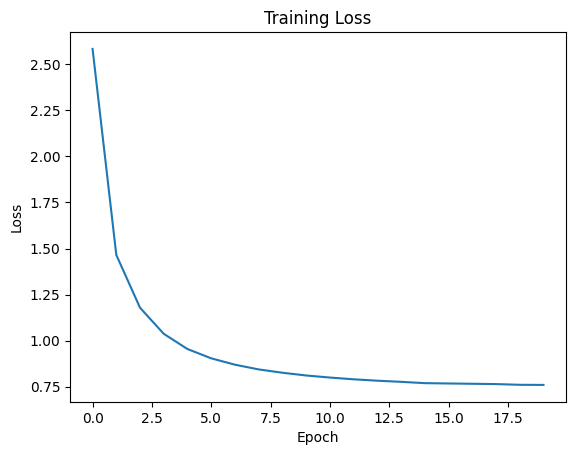

In [86]:
epochs = list(range(len(history['loss'])))
plt.plot(epochs, history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [17]:
tar_tokenizer.word_index['<start>']

2

In [18]:
def predict_seq2seq(encoder, decoder, src_tokens, tar_tokenizer, num_steps):
    enc_X = tf.expand_dims(src_tokens, axis=0)
    mask = tf.expand_dims(enc_X != 0, 1)

    enc_outputs, enc_state = encoder(enc_X, training=False)
    dec_state = enc_state
    dec_X = tf.expand_dims(tf.constant([tar_tokenizer.word_index['<start>']]), axis=0)
    output_seq = []
    attention_weights = []
    for _ in range(num_steps):
        Y, dec_state, att_wgts = decoder(
            dec_X, enc_outputs, dec_state, mask,training=False)
        dec_X = tf.argmax(Y, axis=2)
        pred = tf.squeeze(dec_X, axis=0)
        if pred[0].numpy() == tar_tokenizer.word_index['<end>']:
            break
        output_seq.append(pred[0].numpy())
        attention_weights.append(tf.squeeze(att_wgts, 0))
    attention_weights = tf.squeeze(tf.stack(attention_weights, axis=0), 1)
    return detokenize(output_seq, tar_tokenizer), attention_weights

In [19]:
eng, hin = next(iter(train_dataset))
# print(train_dataset)
# print(eng)

In [20]:
idx = -5
actual_seq = detokenize(hin[idx].numpy(),tar_tokenizer)
translation, att_wgts = predict_seq2seq(encoder, decoder, eng[idx], tar_tokenizer, 10)
eng_sent = detokenize(eng[idx].numpy(), inp_tokenizer)
print(eng_sent)
print(f'Input Sentence:      {eng_sent}')
print(f'Predicted Translation: {translation}')
print(f'Actual Translation:    {actual_seq}')

ich mag solche dinge 
Input Sentence:      ich mag solche dinge 
Predicted Translation: uniforms questioning gymnasium untidy contemptuously age ends measurement outlaw bomb 
Actual Translation:    i like to do things like that 


In [21]:
def translate(lines,inp_tokenizer,tar_tokenizer,encoder,decoder,max_len=10):
    
    exclude = set(string.punctuation)
    prep_lines = []

    for i in lines:
        prep_lines.append([preprocess(i, exclude, sp_tokens=False)])
    
    input_tensors = []

    for i in prep_lines:
        inp = i[0].split(' ')
        tensor = []
        for j in inp:
            # check for oov
            if j not in inp_tokenizer.word_index.keys():
                tensor.append(inp_tokenizer.word_index['<unk>'])
            else:
                tensor.append(inp_tokenizer.word_index[j])
        input_tensors.append(tensor)
            
    for input_tensor in input_tensors:
        temp_max_len = max(max_len,len(input_tensor))
        for i in range(temp_max_len-len(input_tensor)):
            input_tensor.append(0)

    for input_tensor in input_tensors:
        input_tensor = tf.convert_to_tensor(input_tensor)

    translations = []

    for input_tensor in input_tensors:
        translation, _ = predict_seq2seq(encoder, decoder, input_tensor, tar_tokenizer,10)
        translations.append(translation)
    
    print(translations) 
    
    return translations

In [22]:
print(translate(["anuj","how are you?"],inp_tokenizer,tar_tokenizer,encoder=encoder,decoder=decoder))

['accepted skunk connected fantastic signs blame download download bewildered bewildered ', 'accepted accepted skunk inhibitions signs download download bewildered signs blame ']
['accepted skunk connected fantastic signs blame download download bewildered bewildered ', 'accepted accepted skunk inhibitions signs download download bewildered signs blame ']


In [23]:
def get_df(lines):
    translation = {'Tokenised Original':[],'Reference':[],'Translation':[]}
    lines = lines[:50]
    text = []
    ref = []
    trans = []
    for i in lines:
        t = i.split('\t')
        text.append(t[0])
        ref.append(t[1])   
    trans = translate(text,inp_tokenizer,tar_tokenizer,encoder=encoder,decoder=decoder)
    for i in range(len(trans)):
        translation['Tokenised Original'].append(text[i])
        translation['Reference'].append(ref[i])
        translation['Translation'].append(trans[i])
    df = pd.DataFrame(translation)
    return df


In [24]:
df = get_df(lines)
df

['farther unintelligent ah swelling liquid locating bookkeeping climb foots wellbeing ', 'digital gucci soldiers gain soldiers secondrate mother microscope crouched digital ', 'lavender fortunately index loud loud loud approximately loud loud sprouted ', 'decorating talk faded lifeordeath granted granted student squatting chalk gi ', 'liquor blackie deal boards cooler crafty crafty skateboard york york ', '1941 updated horn 89 undefeated 89 mock alice alice beasts ', 'squeaked solomon brushed diagonally precious diagonally precious solomon brushed brushed ', 'spotlight lent reply snoozed snoozed simplest delete fog simplest fog ', 'astonishment dwell eats advantage embarrassing juice slam opposing around bullet ', 'worry diamonds orbits intellectual worry brighten fax robe most divorces ', 'sandwich sandwich ironic bare valentina maruzen mustaches unfolded maruzen unfolded ', 'farther unintelligent ah swelling liquid locating bookkeeping climb foots wellbeing ', 'jeep beards unfortunat

,Tokenised Original,Reference,Translation
0,Hallo!,Hi.,farther unintelligent ah swelling liquid locat...
1,Grüß Gott!,Hi.,digital gucci soldiers gain soldiers secondrat...
2,Lauf!,Run!,lavender fortunately index loud loud loud appr...
3,Potzdonner!,Wow!,decorating talk faded lifeordeath granted gran...
4,Donnerwetter!,Wow!,liquor blackie deal boards cooler crafty craft...
5,Feuer!,Fire!,1941 updated horn 89 undefeated 89 mock alice ...
6,Hilfe!,Help!,squeaked solomon brushed diagonally precious d...
7,Zu Hülf!,Help!,spotlight lent reply snoozed snoozed simplest ...
8,Stopp!,Stop!,astonishment dwell eats advantage embarrassing...
9,Warte!,Wait!,worry diamonds orbits intellectual worry brigh...


In [95]:
import pickle
with open('encoder_attention_v1.pickle', 'wb') as f:
    pickle.dump(encoder, f)
with open('decoder_attention_v1.pickle', 'wb') as f:
    pickle.dump(decoder, f)

In [25]:
print(translate(["wo ist er"],inp_tokenizer,tar_tokenizer,encoder=encoder,decoder=decoder))

['answering mysteries crossbow inflatable llama filled grapevine aardvarks done must ']
['answering mysteries crossbow inflatable llama filled grapevine aardvarks done must ']


In [97]:
with open('X_tokenizer.pickle', 'wb') as f:
    pickle.dump(inp_tokenizer, f)

with open('Y_tokenizer.pickle', 'wb') as f:
    pickle.dump(tar_tokenizer, f)

In [1]:
import pickle
# encoder_loaded = pickle.load(open('encoder_attention_v1.pickle', 'rb'))
# decoder_loaded = pickle.load(open('decoder_attention_v1.pickle', 'rb'))


# print(encoder_loaded)
# print(decoder_loaded)
X_tokenizer_loaded = pickle.load(open('X_tokenizer.pickle', 'rb'))
Y_tokenizer_loaded = pickle.load(open('Y_tokenizer.pickle', 'rb'))

# print(translate(["ich bin klug"],X_tokenizer_loaded,Y_tokenizer_loaded,encoder=encoder_loaded,decoder=decoder_loaded))

In [2]:
encoder_loaded = pickle.load(open('encoder_attention_v1.pickle', 'rb'))


KeyboardInterrupt: 

In [122]:
print(translate(["ich bin"],X_tokenizer_loaded,Y_tokenizer_loaded,encoder=encoder_loaded,decoder=decoder_loaded))

['im easygoing ']
['im easygoing ']
